In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier
import pprint
import sklearn.preprocessing as prep 
from sklearn.feature_selection import mutual_info_classif
from sklearn import feature_selection
from sklearn import linear_model

In [2]:
# retrieve the data

path = os.getcwd()
data = pd.read_csv(path + '/alldata.csv',sep = ',', index_col = [0,1])
data.index.names = ['Year', 'State']

# create yield intervals
bins = [0, 40.5, 50, 65.5, 200]
names = [0, 1, 2, 3, 4]
d = dict(enumerate(names, 1))
data['YieldClass'] = np.vectorize(d.get)(np.digitize(data['YieldPerColony'], bins))

# drop oritinal targeted variable
data = data.drop('YieldPerColony',1)

# sepearte targeted variable and features
Y = data['YieldClass']
X = data.drop('YieldClass',1)

## Mutual Information

In [3]:
def get_plot(X, value, label):
    keys = X.columns.values.tolist()
    dict_value = dict(zip(keys,value))
    dict_value = sorted(dict_value.items(), key = lambda kv: kv[1], reverse = True)
    %matplotlib inline
    plt.rcParams['figure.figsize'] = 12, 12
    plt.bar(*zip(*dict_value))
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), rotation = 30, horizontalalignment = 'right')
    plt.ylabel(label)
    return(dict_value)

[('ValueOfProduction', 0.28898862094909905),
 ('ColoniesFromHoney', 0.28168759557738454),
 ('Awnd', 0.23714082081190524),
 ('Tavg', 0.15590539884384835),
 ('Production', 0.14113193400403157),
 ('AveragePricePerPound', 0.13927488450652836),
 ('AvgQuarterlyColonies', 0.13852979597520232),
 ('Prcp', 0.10463752923817049),
 ('MaximumColonies', 0.09504686534658147),
 ('PercentLost', 0.08855301607689547),
 ('Dp10', 0.05166472131545863),
 ('Snow', 0.03775798029764443),
 ('VarroaMites', 0.037161763409627735),
 ('LostColonies', 0.028620051296014193),
 ('Pesticides', 0.02711086317576683),
 ('StocksDecember', 0.025575149432653266),
 ('AddedColonies', 0.024280918573469368),
 ('RenovatedColonies', 0.013314149715108137),
 ('UnknownDiseases', 0.0019116033907846663),
 ('PercentRenovated', 0.0),
 ('OtherPestsAndParasites', 0.0),
 ('Diseases', 0.0),
 ('OtherDiseases', 0.0),
 ('Evap', 0.0)]

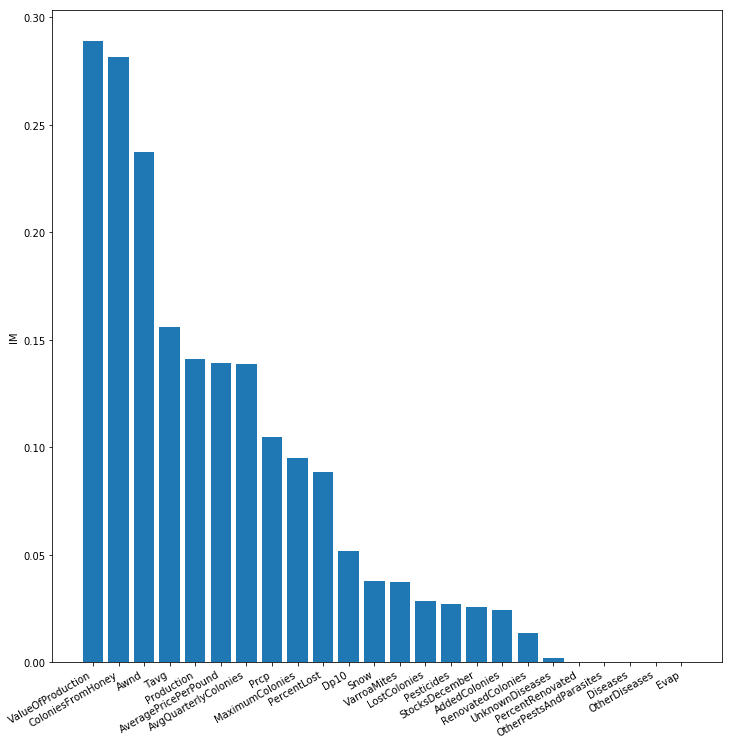

In [4]:
# normalize features
X_norm = prep.scale(X, axis = 0, with_mean = True, with_std = True)
X_norm = pd.DataFrame(X_norm,index = X.index, columns = X.columns)

# computer MI score
feature_scores = mutual_info_classif(X_norm,Y)
get_plot(X_norm, feature_scores, 'IM')

## Lasso

In [5]:
alpha = np.linspace(0.1,0.8,10)

coef = {}
for i in alpha:
    clf = linear_model.Lasso(i, fit_intercept = False)
    fitted = clf.fit(X_norm, Y)
    coef_i = fitted.coef_
    coef[i] = coef_i

coef_df = pd.DataFrame.from_dict(coef)
coef_df= coef_df.set_index(X_norm.columns.values)
coef_df = coef_df.T

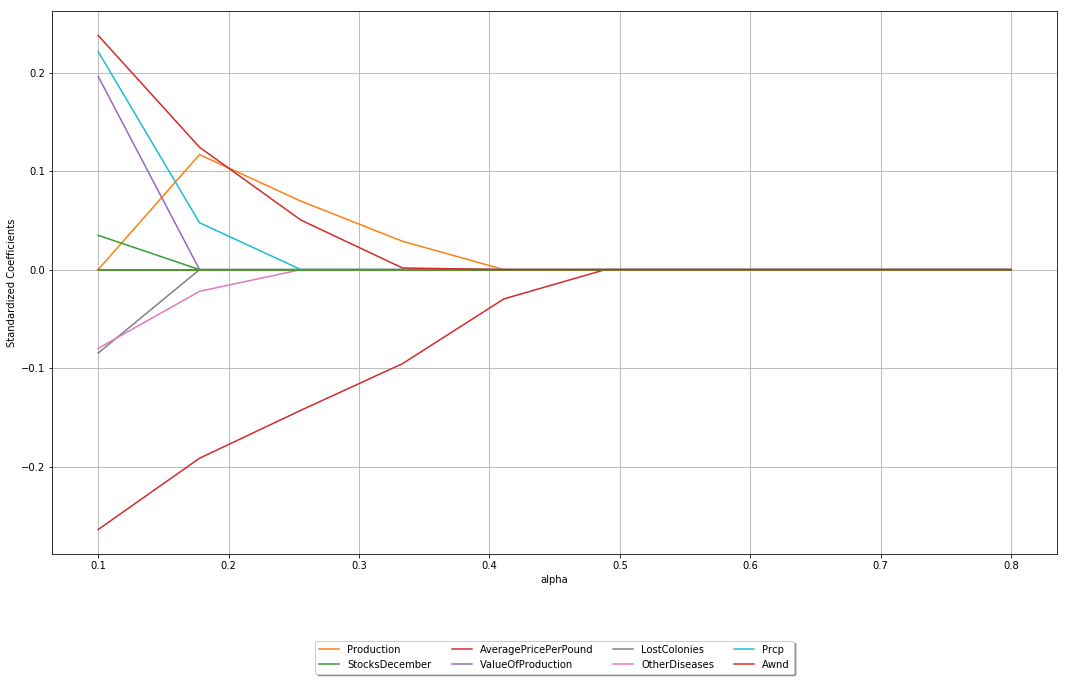

In [6]:
fig = plt.figure(figsize = (18, 10))
ax = plt.subplot(111)
for i in coef_df.columns.values:
    if coef_df[i].sum() == 0:
        coef_df[i].plot(label ='_')
    else:
        coef_df[i].plot(legend = True)


ax.grid()
box = ax.get_position()
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
             shadow = True, ncol = 4, prop = {'size':10})
plt.show()